In [12]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [33]:
using JuMP, Ipopt, LinearAlgebra, StaticArrays, Plots

# === (1) Helper functions & parameters (unchanged) ===
function uni_dyna(x, u)
    return @SVector [
        x[1] + dt * u[1] * cos(x[3]),
        x[2] + dt * u[1] * sin(x[3]),
        x[3] + dt * u[2]
    ]
end

function circleShape(h, k, r)
    theta = LinRange(0, 2π, 500)
    return h .+ r .* sin.(theta), k .+ r .* cos.(theta)
end

N_total = 100       # total horizon
horizon  = 25       # MPC horizon
tf       = 10.0
dt       = tf / N_total   # = 0.1
u1_b     = 0.15
u2_b     = 0.75

xo = @SVector [10.0, 0.0]
ro = 4.0
ra = 3.0

Q  = Diagonal(@SVector [50,10,5,50,10,5,5,5,2,2]) * 0.6
Qf = Diagonal(@SVector [50,10,5,50,10,5,5,5,2,2]) * 50
R  = Diagonal(@SVector [10,10,5,5]) * 0.8

noise_level = 1.0
num_sim     = 2

# === (2) Outer loop over “sim = 1:num_sim” ===
for sim in 1:num_sim
    # --- (2a) Generate x0, xf with noise (unchanged) ---
    base_x0 = @SVector [0.0, 0.0, 0.0, 20.0, 0.0, π]
    noise0  = @SVector [
        noise_level*(2*rand()-1),
        noise_level*(2*rand()-1),
        0.0,
        noise_level*(2*rand()-1),
        noise_level*(2*rand()-1),
        0.0
    ]
    x0 = base_x0 + noise0

    base_xf = @SVector [20.0, 0.0, 0.0, 0.0, 0.0, π]
    noisef  = @SVector [
        noise_level*(2*rand()-1),
        noise_level*(2*rand()-1),
        0.0,
        noise_level*(2*rand()-1),
        noise_level*(2*rand()-1),
        0.0
    ]
    xf = base_xf + noisef

    # --- (2b) Precompute full reference (N_total+1 × 10) ---
    X_ref = hcat(
      collect(LinRange(x0[1], xf[1], N_total+1)),
      collect(LinRange(x0[2], xf[2], N_total+1)),
      collect(LinRange(x0[3], xf[3], N_total+1)),
      collect(LinRange(x0[4], xf[4], N_total+1)),
      collect(LinRange(x0[5], xf[5], N_total+1)),
      collect(LinRange(x0[6], xf[6], N_total+1)),
      zeros(N_total+1),  # u11_ref
      zeros(N_total+1),  # u12_ref
      zeros(N_total+1),  # u21_ref
      zeros(N_total+1)   # u22_ref
    )

    # --- (2c) Allocate storage for the MPC‐executed path ---
    X1_hist = zeros(N_total+1, 3)
    X2_hist = zeros(N_total+1, 3)
    U_hist  = zeros(N_total,   4)

    # Initialize with x0
    X1_hist[1, :] = x0[1:3]
    X2_hist[1, :] = x0[4:6]
    x1_curr = x0[1:3]
    x2_curr = x0[4:6]

    # === (3) MPC loop: for k = 1…100 ===
    for k in 1:N_total
        horizon_h = min(horizon, N_total - k + 1)
        Xref_seg  = X_ref[k : k + horizon_h, :]    # (horizon_h+1)×10

        # === (3a) Build & solve a “25‐step” JuMP subproblem ===
        model = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model, "print_level", 0)  # suppress prints

        @variable(model, x11[1:horizon_h+1])
        @variable(model, x12[1:horizon_h+1])
        @variable(model, x13[1:horizon_h+1])
        @variable(model, x21[1:horizon_h+1])
        @variable(model, x22[1:horizon_h+1])
        @variable(model, x23[1:horizon_h+1])

        @variable(model, 0 <= u11[1:horizon_h+1], start = 0.0)
        @variable(model,        u12[1:horizon_h+1], start = 0.0)
        @variable(model, 0 <= u21[1:horizon_h+1], start = 0.0)
        @variable(model,        u22[1:horizon_h+1], start = 0.0)

        @variable(model, -u1_b <= du11[1:horizon_h+1] <= u1_b, start = 0.0)
        @variable(model, -u2_b <= du12[1:horizon_h+1] <= u2_b, start = 0.0)
        @variable(model, -u1_b <= du21[1:horizon_h+1] <= u1_b, start = 0.0)
        @variable(model, -u2_b <= du22[1:horizon_h+1] <= u2_b, start = 0.0)

        # Fix initial states in this horizon to the “current” state
        fix(x11[1], x1_curr[1], force = true)
        fix(x12[1], x1_curr[2], force = true)
        fix(x13[1], x1_curr[3], force = true)
        fix(x21[1], x2_curr[1], force = true)
        fix(x22[1], x2_curr[2], force = true)
        fix(x23[1], x2_curr[3], force = true)

        # Fix terminal controls to zero
        fix(u11[horizon_h+1], 0.0, force = true)
        fix(u12[horizon_h+1], 0.0, force = true)
        fix(u21[horizon_h+1], 0.0, force = true)
        fix(u22[horizon_h+1], 0.0, force = true)
        fix(du11[horizon_h+1], 0.0, force = true)
        fix(du12[horizon_h+1], 0.0, force = true)
        fix(du21[horizon_h+1], 0.0, force = true)
        fix(du22[horizon_h+1], 0.0, force = true)

        # Build X_full and U_full for the cost (10×(horizon_h+1), 4×(horizon_h+1))
        X_full = vcat(
          x11', x12', x13',
          x21', x22', x23',
          u11', u21', u12', u22'
        )
        U_full = vcat(du11', du21', du12', du22')

        # === Objective = sum_{t=1:horizon_h} [Δx'QΔx + Δu'RΔu] + terminal Δx'QfΔx ===
        @objective(model, Min,
          # (i) Running‐cost on state+control
          sum(
            begin
              Δx = @SVector [
                x11[t] - Xref_seg[t,1],
                x12[t] - Xref_seg[t,2],
                x13[t] - Xref_seg[t,3],
                x21[t] - Xref_seg[t,4],
                x22[t] - Xref_seg[t,5],
                x23[t] - Xref_seg[t,6],
                u11[t] - Xref_seg[t,7],
                u21[t] - Xref_seg[t,9],
                u12[t] - Xref_seg[t,8],
                u22[t] - Xref_seg[t,10]
              ]
              Δx' * Q * Δx
            end
            for t in 1:horizon_h
          )
          +
          # (ii) Running‐cost on control increments
          sum(
            begin
              Δu = @SVector [du11[t], du21[t], du12[t], du22[t]]
              Δu' * R * Δu
            end
            for t in 1:horizon_h
          )
          +
          # (iii) Terminal‐cost at t = horizon_h+1
          begin
            ΔxT = @SVector [
              x11[horizon_h+1] - Xref_seg[horizon_h+1,1],
              x12[horizon_h+1] - Xref_seg[horizon_h+1,2],
              x13[horizon_h+1] - Xref_seg[horizon_h+1,3],
              x21[horizon_h+1] - Xref_seg[horizon_h+1,4],
              x22[horizon_h+1] - Xref_seg[horizon_h+1,5],
              x23[horizon_h+1] - Xref_seg[horizon_h+1,6],
              u11[horizon_h+1] - Xref_seg[horizon_h+1,7],
              u21[horizon_h+1] - Xref_seg[horizon_h+1,9],
              u12[horizon_h+1] - Xref_seg[horizon_h+1,8],
              u22[horizon_h+1] - Xref_seg[horizon_h+1,10]
            ]
            ΔxT' * Qf * ΔxT
          end
        )

        # === Constraints (dynamics, increments, collision/obstacle) ===
        @constraint(model, [t in 1:horizon_h],
          x11[t] + dt * u11[t] * cos(x13[t]) == x11[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          x12[t] + dt * u11[t] * sin(x13[t]) == x12[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          x13[t] + dt * u12[t]             == x13[t+1]
        )

        @constraint(model, [t in 1:horizon_h],
          x21[t] + dt * u21[t] * cos(x23[t]) == x21[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          x22[t] + dt * u21[t] * sin(x23[t]) == x22[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          x23[t] + dt * u22[t]             == x23[t+1]
        )

        @constraint(model, [t in 1:horizon_h],
          u21[t] + du21[t+1] == u21[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          u22[t] + du22[t+1] == u22[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          u11[t] + du11[t+1] == u11[t+1]
        )
        @constraint(model, [t in 1:horizon_h],
          u12[t] + du12[t+1] == u12[t+1]
        )

        @constraint(model, [t in 1:horizon_h+1],
          (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0
        )
        @constraint(model, [t in 1:horizon_h+1],
          (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0
        )
        @constraint(model, [t in 1:horizon_h+1],
          (xo[1] - x21[t])^2 + (xo[2] - x22[t])^2 - ro^2 >= 0
        )

        # === Warm start from reference ===
        for i in 1:(horizon_h+1)
          set_start_value(x11[i], Xref_seg[i,1] + 0.1*(2*rand()-1))
          set_start_value(x12[i], Xref_seg[i,2] + 0.1*(2*rand()-1))
          set_start_value(x13[i], Xref_seg[i,3] + 0.1*(2*rand()-1))
          set_start_value(x21[i], Xref_seg[i,4] + 0.1*(2*rand()-1))
          set_start_value(x22[i], Xref_seg[i,5] + 0.1*(2*rand()-1))
          set_start_value(x23[i], Xref_seg[i,6] + 0.1*(2*rand()-1))

          set_start_value(u11[i], Xref_seg[i,7])
          set_start_value(u12[i], Xref_seg[i,8])
          set_start_value(u21[i], Xref_seg[i,9])
          set_start_value(u22[i], Xref_seg[i,10])

          set_start_value(du11[i], 0.0)
          set_start_value(du12[i], 0.0)
          set_start_value(du21[i], 0.0)
          set_start_value(du22[i], 0.0)
        end

        optimize!(model)

        ts = termination_status(model)
        ps = primal_status(model)
        println("MPC step $k: termination_status = $ts, primal_status = $ps")

        # <<< ALLOW LOCALLY_SOLVED OR OPTIMAL >>>
        if ts != MOI.OPTIMAL && ts != MOI.LOCALLY_SOLVED
          println("  → stopping early because solver status = $ts")
          break
        end

        # === Extract the first‐step control from the solution ===
        u11_opt = value(u11[1])
        u12_opt = value(u12[1])
        u21_opt = value(u21[1])
        u22_opt = value(u22[1])

        # === Record & apply that control for exactly one dt ===
        U_hist[k, :] = [u11_opt, u12_opt, u21_opt, u22_opt]

        x1_curr = uni_dyna(x1_curr, @SVector [u11_opt, u12_opt])
        x2_curr = uni_dyna(x2_curr, @SVector [u21_opt, u22_opt])

        X1_hist[k+1, :] = x1_curr
        X2_hist[k+1, :] = x2_curr
    end  # <--- end of MPC loop k=1:100

    # === (4) Now we still have X1_hist, X2_hist (101×3) filled by MPC ===
    xs1 = X1_hist[:, 1]
    ys1 = X1_hist[:, 2]
    xs2 = X2_hist[:, 1]
    ys2 = X2_hist[:, 2]

    # Plot the full 100‐step MPC‐executed trajectories:
    plot(xs1, ys1;
         color = :blue,
         lw = 2,
         label = "Agent 1 (MPC‐executed)")
    plot!(xs2, ys2;
          color = :orange,
          lw = 2,
          label = "Agent 2 (MPC‐executed)")

    # Draw the obstacle circle in the background:
    cox, coy = circleShape(xo[1], xo[2], ro)
    plot!(cox, coy;
          seriestype = :shape,
          lw = 0.5,
          c = :gray,
          linecolor = :white,
          fillalpha = 0.2,
          legend = false,
          aspect_ratio = :equal)

    xlabel!("x")
    ylabel!("y")
    title!("MPC‐Executed Trajectories (100 steps)")
end  # <--- end of for sim in 1:num_sim


MPC step 1: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 2: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 3: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 4: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 5: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 6: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 7: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 8: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 9: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 10: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 11: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 12: termination_status = LOCALLY_SOLVED, primal_status = FEASIBLE_POINT
MPC step 13: termination_status = LOC

In [27]:
# ----------------------------------------
# (A) Plotting the MPC‐executed 100‐step trajectories
# ----------------------------------------
# Assume X1_hist is (101×3) and X2_hist is (101×3) from your MPC code:
#    X1_hist[t, :] = [x₁(t), x₂(t), θ(t)] for Agent 1
#    X2_hist[t, :] = [x₁(t), x₂(t), θ(t)] for Agent 2
#
# If you want just the XY‐positions, do:
xs1 = X1_hist[:, 1]
ys1 = X1_hist[:, 2]
xs2 = X2_hist[:, 1]
ys2 = X2_hist[:, 2]

# Create a new plot window (clears any old curves)
plot(
    xs1, ys1,
    color = :blue,
    label = "Agent 1 (MPC‐executed)",
    lw = 2
)
plot!(
    xs2, ys2,
    color = :orange,
    label = "Agent 2 (MPC‐executed)",
    lw = 2
)

# Draw the circular obstacle for reference:
cox, coy = circleShape(xo[1], xo[2], ro)
plot!(
    cox, coy;
    seriestype = :shape,
    lw = 0.5,
    c = :gray,
    linecolor = :white,
    fillalpha = 0.2,
    legend = false
)

xlabel!("x")
ylabel!("y")
title!("MPC‐Executed Trajectories (100 steps)")
aspect_ratio!(:equal)


UndefVarError: UndefVarError: `X1_hist` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

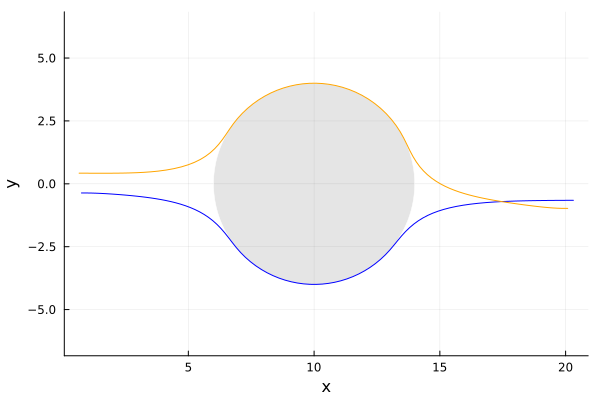

In [14]:
Plots.xlabel!("x")
Plots.ylabel!("y")

In [7]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

4.612369206615606
1.269209194669525
4.692649627544472
4.472568210126472
20.717985684492845
7.003708031789579
1.4074413785132767
20.99995003728337
7.0039000350925305
4.574391984781304


In [8]:
CSV.write("data/asym_trajs_noise1.csv",  Tables.table(full_traj), writeheader=false)

"data/asym_trajs_noise1.csv"

In [9]:
load_traj = Array(CSV.read("data/asym_trajs_noise1.csv",DataFrame,header=false);)

100000×10 Matrix{Float64}:
  2.10453      0.128088    2.16601      …  20.893      2.3922   3.14159
  2.10506      0.11035     2.16641         20.6764     2.3922   3.15247
  2.10568      0.0874879   2.16687         20.4598     2.38985  3.16162
  2.10622      0.0657492   2.16723         20.2432     2.38551  3.16851
  2.10663      0.0477695   2.16746         20.0265     2.37968  3.17319
  2.10692      0.0342509   2.16757      …  19.8099     2.37283  3.17598
  2.10713      0.0249552   2.16758         19.5933     2.36538  3.17725
  2.10728      0.0192648   2.16753         19.3766     2.35765  3.17733
  2.1074       0.0164814   2.16742         19.16       2.34991  3.17651
  2.10751      0.0159694   2.16728         18.9434     2.34234  3.175
  ⋮                                     ⋱                       
  1.2          0.00477793  1.2              0.2858     1.53201  3.14775
  1.05         0.00483365  1.05             0.165803   1.53127  3.14718
  0.9          0.00534145  0.9              0.

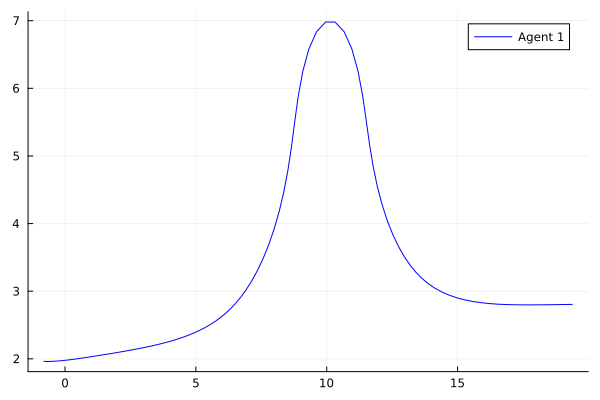

In [14]:
traj = load_traj[101:200, :]  # select rows 1 to 100, and all columns
Plots.plot(traj[:,5],traj[:,6],color="blue",label="Agent 1")
# Plots.plot(traj[:,4],traj[:,5],color="orange",label="Agent 2")

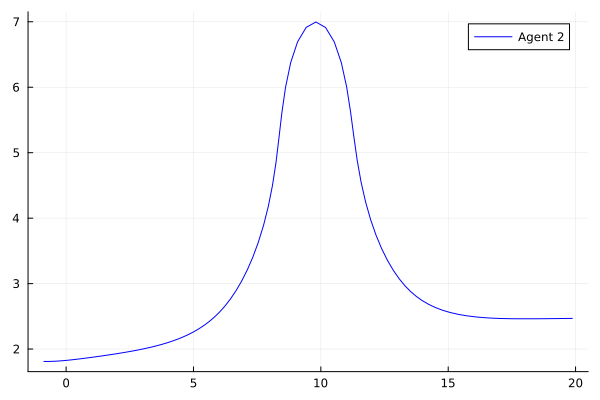

In [ ]:
traj2 = load_traj[1:100, :]  # select rows 1 to 100, and all columns
Plots.plot(traj[:,5],traj[:,6],color="blue",label="Agent 1")
